In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


mtalbert_soil = pd.read_csv("../EcologyDistrict/AcrossStationData/MtAlbert_Data_Hourly.csv", index_col='Timestamp (UTC+12:00)', parse_dates=True)
mtalbert_soil.head()

,Rain(mm),SoilTemp(c),SoilMoisture(%)
Timestamp (UTC+12:00),,,
2019-05-26 06:00:00,0.0,14.4000,41.620375
2019-05-26 07:00:00,0.0,14.3625,41.610875
2019-05-26 08:00:00,0.0,14.3000,41.591000
2019-05-26 09:00:00,0.0,14.3625,41.594750
2019-05-26 10:00:00,0.0,14.4000,41.582875


In [4]:
mtalbert_soil.index.freq = 'H'

C:\Users\Ying\AppData\Local\Temp\ipykernel_21384\3173936285.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  mtalbert_soil.index.freq = 'H'


In [5]:
mtalbert_soil.index.freq

<Hour>

In [6]:
mtalbert_soil.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 47370 entries, 2019-05-26 06:00:00 to 2024-10-19 23:00:00
Freq: h
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Rain(mm)         47370 non-null  float64
 1   SoilTemp(c)      47370 non-null  float64
 2   SoilMoisture(%)  47370 non-null  float64
dtypes: float64(3)
memory usage: 1.4 MB


<Axes: xlabel='Timestamp (UTC+12:00)'>

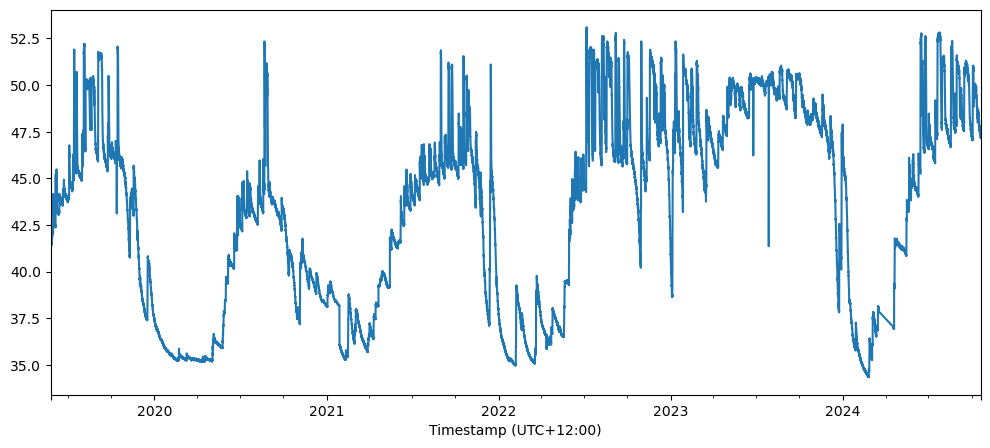

In [7]:
mtalbert_soil['SoilMoisture(%)'].plot(figsize=(12, 5))

### Perform a Seasonal Decomposition on the model and plot out the ETS components

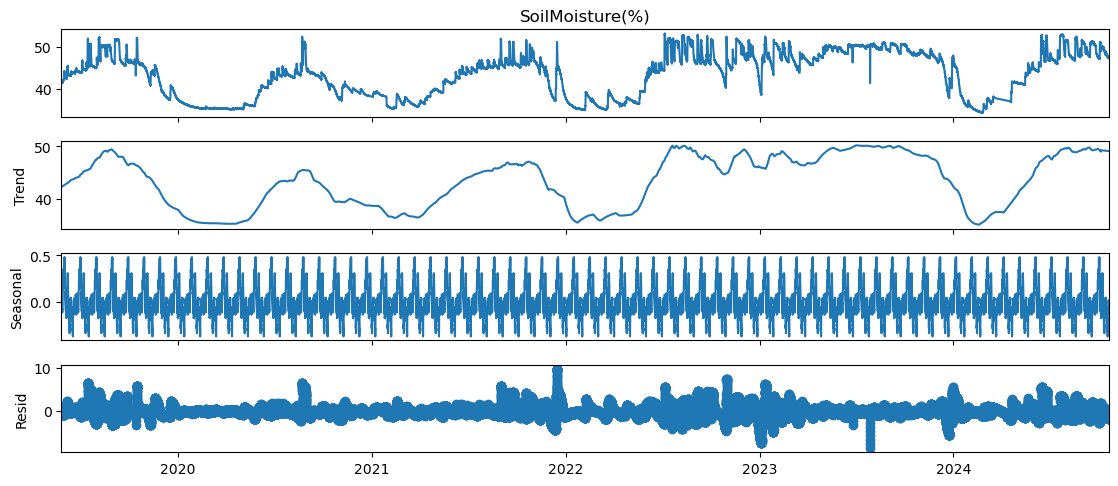

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
auckalnd_daily_seaonal = seasonal_decompose(mtalbert_soil['SoilMoisture(%)'], model='additive', period=720, extrapolate_trend='freq') 
fig = auckalnd_daily_seaonal.plot()
fig.set_size_inches((12, 5))
plt.show()

Above show it is a some seasonal and trend there, deseasonalize and detrend is needed --> Normalize / Scale the data to betwee 0 and 1 for more accurate predictions
- Better approach is to scale after split the data into training and test sets to avoid data leadage. 

### Split the data into a train/test split where the test set is the last 30days of data

In [9]:
len(mtalbert_soil)

47370

For New Zealand, a preiod of arround two months with well-below normal rainfall is usually sufficient to trigger droought-like conditions( perscomm., Alan Porteous, NIWA)

In [10]:
47370 - (60*24)

45930

In [11]:
train = mtalbert_soil.iloc[:45930]
test = mtalbert_soil.iloc[45930:]

In [12]:
len(test)

1440

### Scale Data using MinMaxScaler

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler()

In [15]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

### Time Series Generator object based off the scaled_train data. 
- The n_inputs is base on taking how many historical step to predict the next 1 step to the future, for 1 months will wil 30 point for daily data. or 2 months for 60 points

In [16]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

- pass in twice in TimeseriesGenerator for train set before it is the source of X(features), and source of y(label)

In [17]:
n_input = 24
n_features = 3
target_variable = scaled_train[:, 2]
generator = TimeseriesGenerator(scaled_train, target_variable, length=n_input, batch_size=1)

In [18]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=n_input, batch_size=1)


### Create a Keras Sequential Model

In [19]:
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Input, Dense, LSTM


In [20]:
model = Sequential()

# Add an input 
model.add(Input(shape=(n_input, n_features)))

# how many neuron --> at the moment 150
model.add(LSTM(150, activation='relu'))
model.add(Dense(1)) # For a single-day prediction
# model.add(Dense(30)) 
# model.add(Dense(60))  # For a 60-day forecast


model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 150)            │        92,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,551 (361.53 KB)

 Trainable params: 92,551 (361.53 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# model.fit_generator(generator, epochs=25)
model.fit(generator, epochs=25)


c:\Users\Ying\.conda\envs\level8\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


45906/45906 ━━━━━━━━━━━━━━━━━━━━ 630s 13ms/step - loss: 7.9568e-04
Epoch 2/25
45906/45906 ━━━━━━━━━━━━━━━━━━━━ 646s 14ms/step - loss: 6.5058e-05
Epoch 3/25
45906/45906 ━━━━━━━━━━━━━━━━━━━━ 595s 13ms/step - loss: 5.8079e-05
Epoch 4/25
45906/45906 ━━━━━━━━━━━━━━━━━━━━ 582s 13ms/step - loss: 5.7847e-05
Epoch 5/25
45906/45906 ━━━━━━━━━━━━━━━━━━━━ 546s 12ms/step - loss: 5.4336e-05
Epoch 6/25
45906/45906 ━━━━━━━━━━━━━━━━━━━━ 557s 12ms/step - loss: 5.2486e-05
Epoch 7/25
45906/45906 ━━━━━━━━━━━━━━━━━━━━ 643s 14ms/step - loss: 4.9261e-05
Epoch 8/25
45906/45906 ━━━━━━━━━━━━━━━━━━━━ 580s 13ms/step - loss: 4.5980e-05
Epoch 9/25
45906/45906 ━━━━━━━━━━━━━━━━━━━━ 626s 14ms/step - loss: 4.6954e-05
Epoch 10/25
45906/45906 ━━━━━━━━━━━━━━━━━━━━ 618s 13ms/step - loss: 4.7428e-05
Epoch 11/25
45906/45906 ━━━━━━━━━━━━━━━━━━━━ 569s 12ms/step - loss: 6.5809e-05
Epoch 12/25
45906/45906 ━━━━━━━━━━━━━━━━━━━━ 569s 12ms/step - loss: 4.7150e-05
Epoch 13/25
45906/45906 ━━━━━━━━━━━━━━━━━━━━ 569s 12ms/step - loss: 4.16

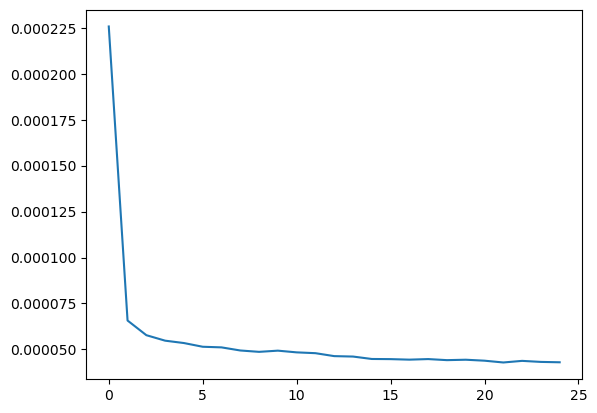

In [22]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

### Evaluate on Test Data

In [23]:
first_eval_batch = scaled_train[-60:]
first_eval_batch

array([[0.        , 0.28213166, 0.93941494],
       [0.01204791, 0.28605016, 0.93588325],
       [0.05977615, 0.29467085, 0.93966815],
       [0.        , 0.30329154, 0.94255348],
       [0.01181622, 0.30799373, 0.94240021],
       [0.01204791, 0.31347962, 0.94264676],
       [0.        , 0.31347962, 0.93977477],
       [0.        , 0.31347962, 0.93822883],
       [0.        , 0.31269592, 0.940721  ],
       [0.        , 0.30721003, 0.9333511 ],
       [0.        , 0.30485893, 0.93332445],
       [0.        , 0.29858934, 0.93674952],
       [0.01181622, 0.29467085, 0.94240688],
       [0.03591203, 0.28918495, 0.93535683],
       [0.        , 0.28291536, 0.94024122],
       [0.        , 0.28213166, 0.9404278 ],
       [0.        , 0.28213166, 0.94040115],
       [0.        , 0.28213166, 0.93790898],
       [0.        , 0.27037618, 0.9345772 ],
       [0.        , 0.26332288, 0.94061438],
       [0.        , 0.25862069, 0.94058773],
       [0.        , 0.25      , 0.94060105],
       [0.

### Generate predictions into the same time stamps as the test set

In [24]:
scaled_train.shape

(45930, 3)

In [27]:
test_predictions = []
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0][0] 
    test_predictions.append(current_pred)
    
    # Create an array to add with the new soil moisture prediction, retaining last values for rain and temp
    new_pred = np.array([[current_batch[0, -1, 0], current_batch[0, -1, 1], current_pred]])
    
    # Append the new prediction to form the next sequence
    current_batch = np.append(current_batch[:, 1:, :], new_pred.reshape(1, 1, n_features), axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [30]:
current_batch

array([[[0.        , 0.22178683, 0.76340377],
        [0.        , 0.22178683, 0.76340377],
        [0.        , 0.22178683, 0.76340377],
        [0.        , 0.22178683, 0.76340377],
        [0.        , 0.22178683, 0.76340377],
        [0.        , 0.22178683, 0.76340377],
        [0.        , 0.22178683, 0.76340377],
        [0.        , 0.22178683, 0.76340377],
        [0.        , 0.22178683, 0.76340377],
        [0.        , 0.22178683, 0.76340377],
        [0.        , 0.22178683, 0.76340377],
        [0.        , 0.22178683, 0.76340377],
        [0.        , 0.22178683, 0.76340377],
        [0.        , 0.22178683, 0.76340377],
        [0.        , 0.22178683, 0.76340377],
        [0.        , 0.22178683, 0.76340377],
        [0.        , 0.22178683, 0.76340377],
        [0.        , 0.22178683, 0.76340377],
        [0.        , 0.22178683, 0.76340377],
        [0.        , 0.22178683, 0.76340377],
        [0.        , 0.22178683, 0.76340377],
        [0.        , 0.22178683, 0

### Inverse Tranformation and Compare

In [40]:
test_predictions_reshaped = np.array(test_predictions).reshape(-1, 1)

test_predictions_expanded = np.zeros((test_predictions_reshaped.shape[0], 3))
test_predictions_expanded[:, 0] = test_predictions_reshaped[:, 0]  # Assuming the target feature is the first column

true_predictions = scaler.inverse_transform(test_predictions_expanded)
true_predictions = true_predictions[:, 0]
true_predictions


array([40.25424504, 40.18273711, 40.11729795, ..., 32.94928983,
       32.94928983, 32.94928983])

In [37]:
test['Prediction'] = true_predictions
test

C:\Users\Ying\AppData\Local\Temp\ipykernel_21384\3237633862.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Prediction'] = true_predictions


,Rain(mm),SoilTemp(c),SoilMoisture(%),Prediction
Timestamp (UTC+12:00),,,,
2024-08-21 00:00:00,0.0,12.9000,51.910000,40.254245
2024-08-21 01:00:00,0.0,12.8250,51.910000,40.182737
2024-08-21 02:00:00,0.0,12.6125,51.907500,40.117298
2024-08-21 03:00:00,0.0,12.4750,51.828000,40.052883
2024-08-21 04:00:00,0.0,12.3875,51.790750,39.989911
...,...,...,...,...
2024-10-19 19:00:00,0.0,16.8125,47.186875,32.949290
2024-10-19 20:00:00,0.0,16.7250,47.184875,32.949290
2024-10-19 21:00:00,0.0,16.5875,47.238875,32.949290


<Axes: xlabel='Timestamp (UTC+12:00)'>

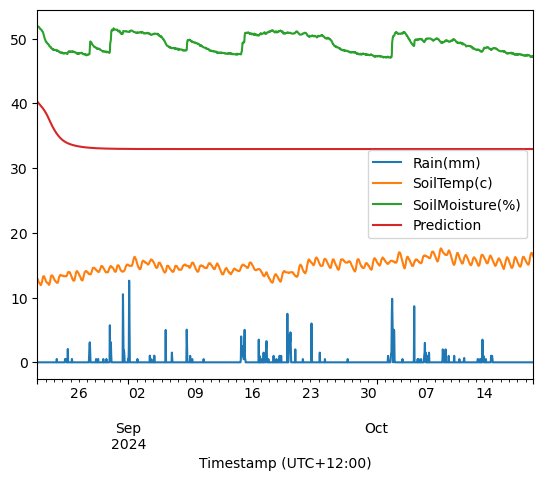

In [38]:
test.plot()

In [42]:
model.save("MtAlbert.SoilMoisturePrediction.h5")
